In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LeaveOneGroupOut, cross_val_score, learning_curve, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import roc_curve, auc, r2_score, make_scorer
from sklearn import metrics
from pymatgen import Composition
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os

In [2]:
def featCleanImpute(Y):
    ''' Convert inf to NaN in feature array, in place
    
    Args: 
        Y, feature array, list of ndarray (#samples x #features)
    Returns:
        None
    '''
    # Clean inf values
    for i in range(len(Y)):
        for j in range(len(Y[i])):
            if Y[i][j] == np.inf:
                Y[i][j] = np.nan
            else:
                Y[i][j] = Y[i][j]
                
    # Impute nan values
    imp = Imputer(missing_values='NaN', axis=0, strategy='mean', copy=False)
    imp2 = Imputer(missing_values='NaN', axis=1, strategy='mean', copy=False)

    imp.fit(Y)
    imp.transform(Y)
    imp2.fit(Y)
    imp.transform(Y)
    

# Build Model: Young's Modulus

Import feature set, import data

In [62]:
with gzip.open('./datasets/youngs_features.pkl.gz', 'rb') as fp:
    X_E = pkl.load(fp)
with gzip.open('./datasets/youngs_data.pkl.gz', 'rb') as fd:
    youngsData = pkl.load(fd)

In [65]:
with gzip.open('./datasets/youngsSmall_features.pkl.gz', 'rb') as fp:
    X_Esmall = pkl.load(fp)
with gzip.open('./datasets/youngsSmall_data.pkl.gz', 'rb') as fd:
    youngsDataSmall = pkl.load(fd)

In [67]:
print(np.where(np.isnan(X_Esmall)))
featCleanImpute(X_Esmall)
print(np.where(np.isnan(X_Esmall)))

(array([ 22,  22,  22, ..., 489, 489, 489], dtype=int64), array([  0,   1,   2, ..., 149, 150, 151], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [50]:
youngs_model = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

In [68]:
# Look at feature importances when trained on the whole data set
youngs_model.fit(X_Esmall, y=youngsDataSmall['E'])

Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [69]:
# make scorer for r2 metric
r2_scorer = make_scorer(r2_score)

In [73]:
youngsDataSmall.head()

,comp,E
0,"(Al, Fe, Co, B, P)",133
1,"(Zr, Cu)",83.5
2,"(Fe, Si, Cu, B, P)",163
3,"(Ni, P, Pd)",108
4,"(Nb, Fe, Co, Si, B)",190


Generate learning curves

In [71]:
train_sizes, train_scores, valid_scores = learning_curve(youngs_model, X_Esmall, youngsDataSmall['E'], cv=ShuffleSplit(),
                                                          scoring=r2_scorer)

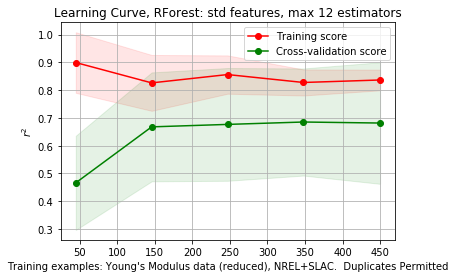

In [72]:
plt.figure()
plt.title('Learning Curve, RForest: std features, max 12 estimators')
plt.xlabel("Training examples: Young's Modulus data (reduced), NREL+SLAC.  Duplicates Permitted")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [75]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
youngsDataSmall['E_predict'] = np.nan
for train_index, test_index in kf.split(youngsDataSmall['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_Esmall[train_index,:], youngsDataSmall['E'][train_index])
    
    y_densPredict = youngs_model.predict(X_Esmall[test_index,:])
    youngsDataSmall['E_predict'][test_index] = y_densPredict
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


(0, 400)

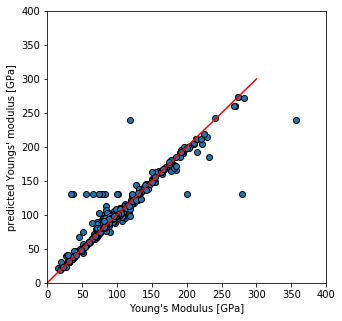

In [79]:
plt.figure(figsize=(5,5))
plt.scatter(youngsDataSmall['E'], youngsDataSmall['E_predict'], edgecolors='k')
plt.plot([0,300], [0,300], 'r-')
plt.xlabel('Young\'s Modulus [GPa]')
plt.ylabel('predicted Youngs\' modulus [GPa]')

plt.xlim([0,400])
plt.ylim([0,400])

In [80]:
youngsDataSmall.iloc[22]

comp            (Ho)
E                 65
E_predict    131.005
Name: 22, dtype: object